In [8]:
import torch
from Models.la_transformer import LightAttention, Decoder, Normi
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Generation of the input fasta to the MLP from the DeepLoc 2.0 CSV file.


In [ ]:
"""The partition mapping is not used in the code and is more so to remember which label is what"""

partition_mapping = {
    0: "Cytoplasm",
    1: "Nucleus",
    2: "Extracellular",
    3: "Cell membrane",
    4: "Mitochondrion",
    5: "Plastid",
    6: "Endoplasmic reticulum",
    7: "Lysosome/Vacuole",
    8: "Golgi apparatus",
    9: "Peroxisome"
}

partition_columns = ['Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane',
                     'Mitochondrion', 'Plastid', 'Endoplasmic reticulum',
                     'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome']

def one_hot_to_class(row):
    for index, value in enumerate(row):
        if value == 1.0:
            return index
    return None

# Load training data
train_data = pd.read_csv('Data/localization/Swissprot_Train_Validation_dataset.csv')  # Replace with the correct path to your CSV file

# Filter out rows with more than one '1' in the partition columns
train_data['ones_count'] = train_data[partition_columns].sum(axis=1)
filtered_train_data = train_data[train_data['ones_count'] == 1].copy()

# Transform one-hot encoding to class labels
filtered_train_data['Class'] = filtered_train_data[partition_columns].apply(one_hot_to_class, axis=1)

# Create FASTA entries for training, validation, and test data
fasta_entries = []
for i, (index, row) in enumerate(filtered_train_data.iterrows()):
    partition = row['Partition']
    if partition in [0, 1, 2]:
        set_type = "train"
        validation_status = "False"
    elif partition == 3:
        set_type = "train"
        validation_status = "True"
    elif partition == 4:
        set_type = "test"
        validation_status = "False"
    else:
        raise ValueError('Unknown Partition.')

    fasta_header = f">Sequence{i} TARGET={row['Class']} SET={set_type} VALIDATION={validation_status}"
    fasta_sequence = row['Sequence']
    fasta_entry = f"{fasta_header}\n{fasta_sequence}"
    fasta_entries.append(fasta_entry)

# Write combined FASTA entries to file
with open('Data/localization/localization.fasta', 'w') as fasta_file:
    fasta_file.write("\n".join(fasta_entries))


This cell was used to read in the localization fasta created by the above cell, to append the hard test set to it and update the train/test/val split.

In [ ]:
from Bio import SeqIO

# Function to update the tags in the first FASTA
def update_tags(records):
    updated_records = []
    for record in records:
        description = record.description.split()
        target = description[1]  # Assuming the format is ">SequenceX TARGET=X ..."
        set_tag = description[2]  # SET=train/test
        validation_tag = description[3]  # VALIDATION=True/False

        # Update the tags
        if "SET=train" in set_tag and "VALIDATION=True" in validation_tag:
            set_tag = "SET=train"
            validation_tag = "VALIDATION=False"
        elif "SET=test" in set_tag:
            set_tag = "SET=train"
            validation_tag = "VALIDATION=True"

        # Rebuild the description with updated tags
        record.description = f"{description[0]} {target} {set_tag} {validation_tag}"
        updated_records.append(record)
    return updated_records

# Load and process the first FASTA file
fasta1 = list(SeqIO.parse("Data/localization/localization.fasta", "fasta"))
fasta1 = update_tags(fasta1)

partition_mapping_inv = {v: k for k, v in partition_mapping.items()}
f1_len = len(fasta1)
print(f1_len)
fasta2 = list(SeqIO.parse("Data/localization/setHARD.fasta", "fasta"))
for i, record in enumerate(fasta2):
        description = record.description.split()
        target = partition_mapping_inv[description[1][:-2].replace(".", " ")]
        new_descr = f"TARGET={target} SET=test VALIDATION=False"
        new_id = f"Sequence{f1_len+i}"
        record.id = new_id
        record.description = new_descr

This part does not run without the model weights, but this is how I generated the fixed LA and LA+Mean embeddings

In [3]:
model = LightAttention(d_model = 512, embeddings_dim= 1024, kernel_size=9, conv_dropout= 0.135)
_ = Decoder(d_model = 512, ff_hidden_layer=1024, prot_emb_size=1024, dropout=0.135,num_layers=2,num_heads=32,max_seq_len=256, vocab_size=23)
normi = Normi(model, _)
checkpoint = torch.load("Weights/light_attention.pth")
normi.load_state_dict(checkpoint["model_state_dict"])

#read in the h5py file that is to be pooled

with h5py.File("Data/localization/localization_hard.h5", 'r') as h5_file:
    ids = list(h5_file.keys())
    embs = [np.array(h5_file[protein_id], dtype=np.float32) for protein_id in ids]

mean_embs = []
la_embs = []
model.eval()
with torch.no_grad():
    for i, emb in enumerate(embs):
        mean_emb = torch.Tensor(emb).mean(dim=0)
        mean_embs.append(mean_emb)
        emb = torch.Tensor(emb)
        e_1 = model(emb.unsqueeze(0).permute(0, 2, 1))[0]
        la_embs.append(e_1)
        if i % 1000 == 0:
            print(f"Pooled embedding {i} out of {len(embs)}")

It is definitely reasonable to normalize the embeddings. For example, my contrastively fine-tuned light attention pooler had embeddings with numbers that were an order of magnitude 400 times larger than the original embeddings. So just concatenating those with the mean does not do alot, as they overshadow the mean embeddings by alot.

In [ ]:
def calculate_magnitudes(embeddings):
    return [np.linalg.norm(embedding) for embedding in embeddings]

def l2_normalize(embeddings):
    normalized_embeddings = []
    for embedding in embeddings:
        norm = np.linalg.norm(embedding)
        if norm == 0:
            normalized_embeddings.append(embedding)
        else:
            normalized_embeddings.append(embedding / norm)
    return normalized_embeddings


# Calculate magnitudes for both sets
magnitudes_set_1 = calculate_magnitudes(la_embs)
magnitudes_set_2 = calculate_magnitudes(mean_embs)

# Compare magnitudes
avg_magnitude_set_1 = np.mean(magnitudes_set_1)
avg_magnitude_set_2 = np.mean(magnitudes_set_2)

print(f"Average magnitude of embeddings in set 1 (contrstve): {avg_magnitude_set_1}")
print(f"Average magnitude of embeddings in set 2 (mean): {avg_magnitude_set_2}")

#comment out the next two lines if the embeddings are not to be normalized. I did not normalize the LA+Mean embeddings
norm_la_embs = l2_normalize(la_embs)
norm_mean_embs = l2_normalize(mean_embs)

concatenated_embeddings = [np.concatenate((e1, e2)) for e1, e2 in zip(norm_la_embs, norm_mean_embs)]

I saved the mean embeddings as well as the combined embeddings, as just inputing the mean embeddings to the mlp is significantly faster than reading in all the per residue embeddings and calculating the mean inside the script.

In [ ]:
with h5py.File("Data/localization/localization_la_mean_hard.h5", 'w') as f:
    for emb, id_ in zip(concatenated_embeddings, ids):
        f.create_dataset(id_, data=emb)

with h5py.File("Data/localization/localization_mean_hard.h5", 'w') as f:
    for emb, id_ in zip(mean_embs, ids):
        f.create_dataset(id_, data=emb)

This is the code I used to generate the boxplots with the output csv of the MLP. It is pretty manual, as the column names of the csv are input by the MLP script user and do not follow a specific formula.

In [4]:
df = pd.read_csv('bootstrapped_localization.csv')
df.head()

,localization_mean,localization_la_tuned,localization_la_mean,localization_mean_easy,localization_la_mean.1
0,0.714286,0.720408,0.718367,0.785145,0.718367
1,0.687755,0.702041,0.712245,0.791940,0.704082
2,0.669388,0.720408,0.704082,0.797095,0.726531
3,0.718367,0.683673,0.712245,0.789128,0.714286
4,0.718367,0.789796,0.702041,0.802015,0.736735


In [10]:

# Read the CSV file

# Select specific columns
selected_columns = df.iloc[:, [0, 1,3,4]]

# Calculate the medians for the selected columns
medians = selected_columns.median().sort_values()

# Sort the dataframe columns based on median values
sorted_columns = medians.index
df_sorted = selected_columns[sorted_columns]

# Check column names and overwrite with custom x-axis labels and colors
print(df_sorted.columns)

Index(['localization_mean', 'localization_la_tuned', 'localization_la_mean.1',
       'localization_mean_easy'],
      dtype='object')


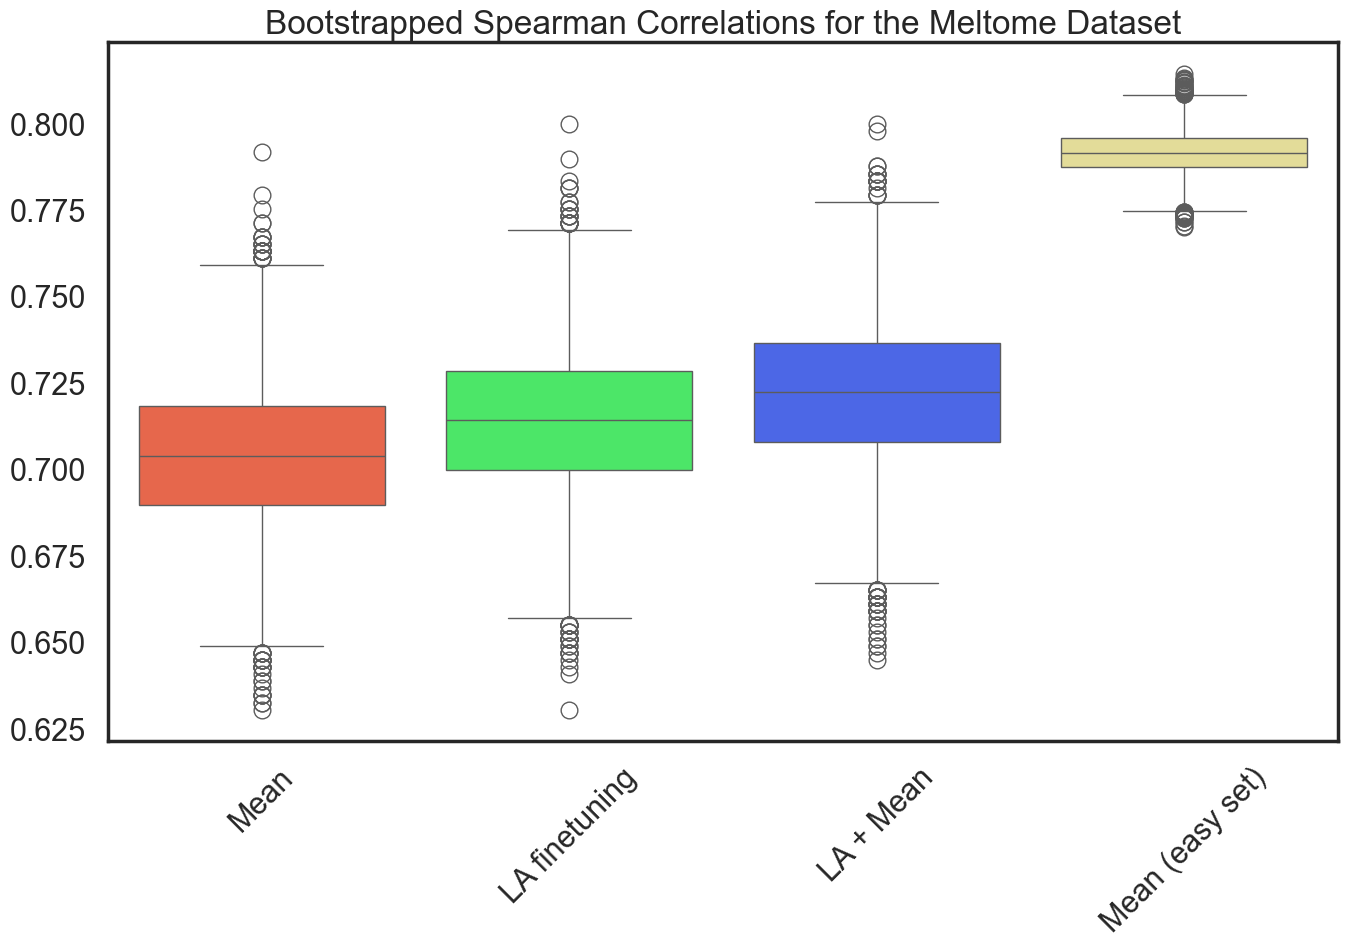

In [11]:
custom_labels = ['Mean', "LA finetuning", 'LA + Mean', 'Mean (easy set)']
custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#F0E68C']

# Set the seaborn context to 'poster' for larger font sizes
sns.set_context("poster")
sns.set_style("white")

# Create the boxplot
plt.figure(figsize=(14, 10))
sns.boxplot(data=df_sorted, palette=custom_colors)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45)
plt.title('Bootstrapped Spearman Correlations for the Meltome Dataset')

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('Boxplots_localization.png')

# Show the plot (optional)
plt.show()
